# PART 1.
> The first section of the notebook will be mostly Generating spikes from the neurons

In [21]:
import numpy as np
import matplotlib.pyplot as plt


In [22]:
"""
This are constants defined in the artificial neuron model.
"""
tau = 0.020  # Membrane time constant in seconds
R = 3e7  # Membrane resistance in ohms
U_rest = -0.07  # Resting potential in volts
theta = -0.030  # Default spike threshold in volts
spike_volt = 0.1  # Voltage at spike in volts
arp = 0.006  # Absolute refractory period in seconds (6 ms)
background_I = 3e-9  # Background noise current in amperes


In [74]:
# Loading the neurons and putting them effectively uncomment the or section to choose the right dataset and keep on with it
real_spike = np.loadtxt('DataSetCoursework_AMA.txt') #or 'DataSetCoursework_POG.txt')
real_spike = real_spike[:, :-2]
first_neuron = real_spike[:, 0]
second_neuron = real_spike[:, 1]
third_neuron = real_spike[:, 2]
fourth_neuron = real_spike[:, 3]
fifth_neuron = real_spike[:, 4]
sixth_neuron = real_spike[:, 5]

# Total simulation period also the total number of rows in the real neuron
dt = 1e-2
total_simulation_time = dt * len(real_spike)
print(sixth_neuron.shape, sixth_neuron.ndim)
print(f'The total simulation time is {total_simulation_time} seconds')

(4836,) 1
The total simulation time is 48.36 seconds


In [75]:
AMA_count_rate_1 = real_spike[:, 0].sum() / total_simulation_time
print(f'The count rate of the first neuron is {AMA_count_rate_1} Hz')

The count rate of the first neuron is 0.35153019023986765 Hz


# Plot Spike Function
> This function can take n neurons and plot the spike count of the spike. We will be using this one for
    plotting spikes from the datasets and spikes from the generated neurons. This function accepts `spikes`, `duration` and `title`

In [30]:
def plot_spike(spike, duration, title="Plot of Spike Raster"):
    """
    Function to plot a spike raster.

    Parameters:
    - spike (ndarray): Input spike data, where each column represents a neuron.
                       For a single neuron, it's a 1D array (time steps).
    - duration (float): Total simulation duration in seconds.
    - title (str): Title for the plot.
    """

    # Check if the input contains a single or multiple neurons
    if spike.ndim == 1:  # Single neuron case (1D array)
        n_neurons = 1
        spike = spike[:, np.newaxis]  # Convert to 2D array for consistent handling
    else:
        n_neurons = spike.shape[1]

    print(f"Number of neurons: {n_neurons}, Spike shape: {spike.shape}")

    # Get the spike times
    spike_times, neurons = np.where(spike > 0)

    # Initialize the plot
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Neurons")

    # Scatter plot for spikes
    plt.scatter(spike_times, neurons + 1, marker="|", color="black", s=100)

    # check the number of neurons passed into this function.
    if n_neurons == 1:
        plt.yticks([1], ["Neuron 1"])
    else:
        plt.yticks(
            ticks=np.arange(1, n_neurons + 1),
            labels=[f"Neuron {i + 1}" for i in range(n_neurons)]
        )

    # Set the x-axis duration
    plt.xlim([0, spike.shape[0]])  # Match time steps to spike length
    plt.grid(axis="y", alpha=0.25, linestyle="--")
    plt.tight_layout()
    plt.show()


Number of neurons: 1, Spike shape: (4305, 1)


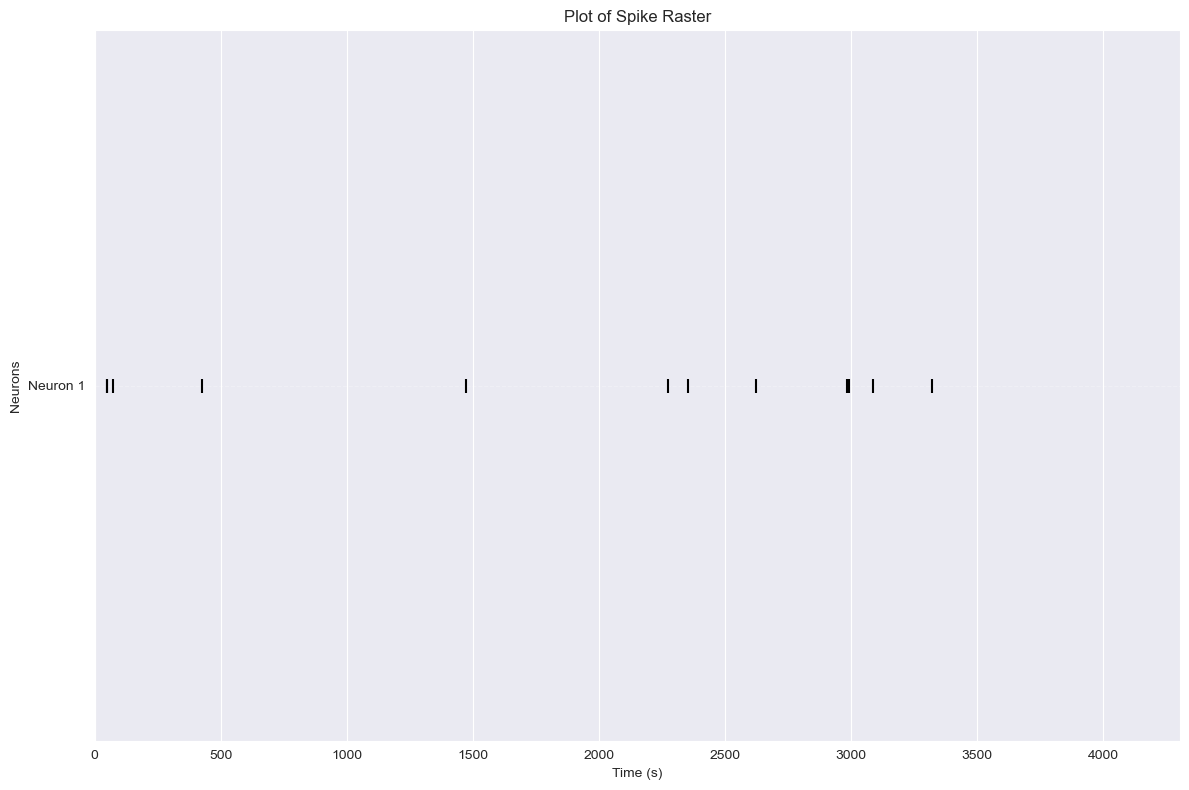

In [31]:
plot_spike(second_neuron, total_simulation_time)

# Leaky integrate-and-fire Function
> This function takes the `input current`, `duration (for our case we used total duration time of the dataset)` and `dt (time step)`. We will be using this function to get the generated neurons.

In [32]:
def leaky_if_3(input_currents, duration, dt):
    """
    Leaky Integrate-and-Fire model:
    Updates to inject spikes at times provided in psc as a 1D array.

    Args:
        input_currents (dict): Dictionary with `U_0`, `psc`, and `ipsc`.
            - `psc`: 1D array specifying times of excitatory spikes.
            - `ipsc`: 1D array specifying times of inhibitory spikes (optional).
        duration (float): Total simulation time (seconds).
        dt (float): Simulation time step (seconds).

    Returns:
        time (np.ndarray): Time array.
        U_plot (np.ndarray): Membrane potential across all timesteps.
        spike_train (np.ndarray): Binary spike train (1 for spikes, 0 otherwise).
    """
    # Extract PSC and IPSC times
    psc = input_currents["psc"]  # Excitatory spike times
    ipsc = input_currents.get("ipsc", [])  # Inhibitory spike times (can be empty)

    U_0 = input_currents["U_0"]  # Baseline potential
    V_th = 1.0  # Threshold potential, example value
    R = 1.0  # Membrane resistance
    tau = 0.02  # Membrane time constant (20 ms)

    # Convert spike times to indices
    n_steps = int(duration / dt)
    time = np.arange(0, duration, dt)  # Discretized simulation time
    U = np.zeros_like(time)  # Initialize membrane potential
    U[0] = U_0  # Set initial potential
    spike_train = np.zeros_like(time)  # Binary spike train

    # Map `psc` and `ipsc` times to indices
    psc_indices = np.round(psc / dt).astype(int)  # Closest indices for psc
    ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []

    # Inject current when spikes occur
    psc_amplitude = 0.5
    ipsc_amplitude = -0.5

    for t in range(1, n_steps):
        # Decay membrane potential
        U[t] = U[t - 1] + (-U[t - 1] + R * 0) * (dt / tau)

        # Add PSC if a spike occurs at this time step
        if t in psc_indices:
            U[t] += psc_amplitude

        # Add IPSC if inhibitory spike occurs at this time step
        if t in ipsc_indices:
            U[t] += ipsc_amplitude

        # Check for spike
        if U[t] >= V_th:
            U[t] = 0  # Reset potential
            spike_train[t] = 1  # Record spike in spike train

    return time, U, spike_train


# The Artificial Neuron Simulation Function
> We have developed this function taking `neuron` and `ipsc`. This helper function is useful in generating any neuron from the real neuron dataset.


Time where spikes happened (indices): [1019 1389 1590 1991 2088 2089 2392 3086 3320 3385 3394 3408 3458 3554
 3717 3862 3997 4152 4377 4378 4534 4636 4669]
Total simulation duration (in ms): 483.6
Number of spikes: 22.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3 1022 1392 1593 1994 2091 2395 3089 3323 3388 3397 3411 3461 3557
 3720 3865 4000 4155 4380 4537 4639 4672]
Number of neurons: 1, Spike shape: (4836, 1)


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


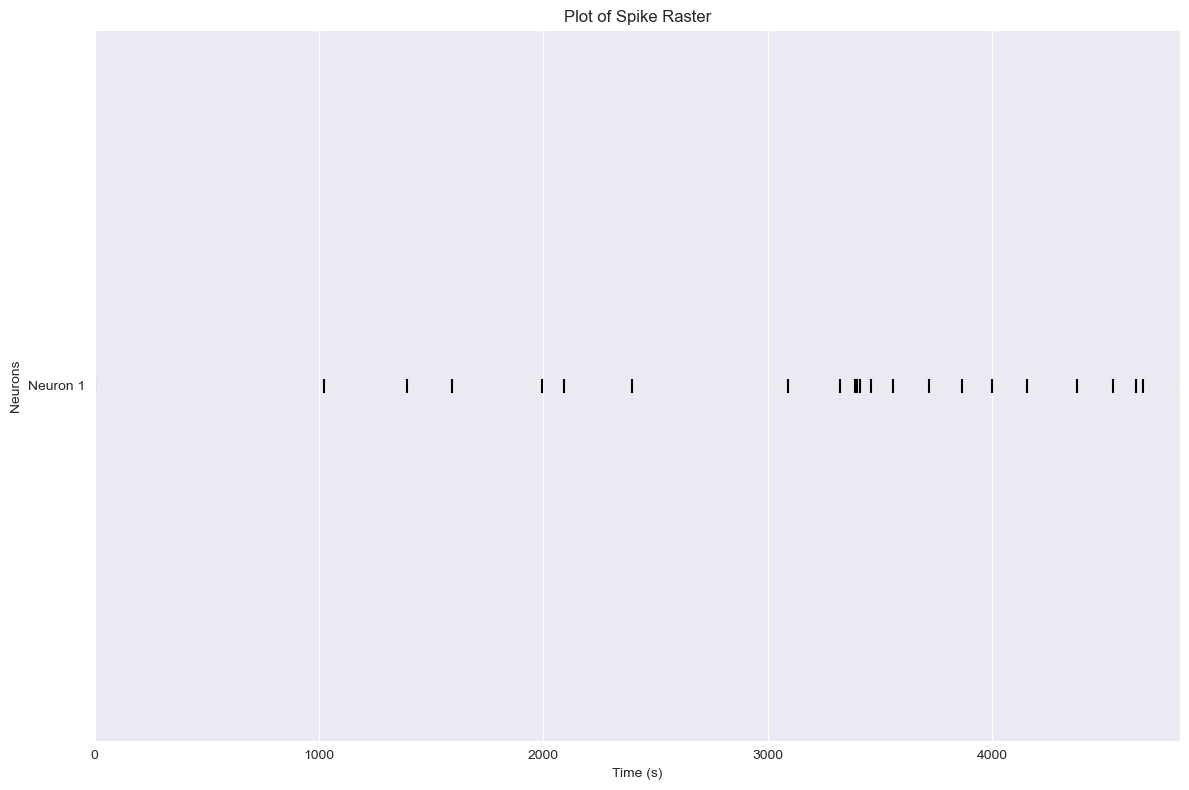

(array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.833e+02, 4.834e+02,
        4.835e+02]),
 array([ 0.3, -1.2,  0. , ...,  0. ,  0. ,  0. ]),
 array([0., 0., 1., ..., 0., 0., 0.]))

In [71]:
"""
Dealing with first neuron to simulate its spike train:
1. Obtain psc from the first neuron as the indices where spikes occur.
2. Use those indices to create a spike train, ensuring all time-related variables are consistently scaled to ms.
3. Ensure the simulation retains the expected duration and proper alignment in ms.
"""


def artificial_neuron_simulation(neuron=first_neuron, ipsc=np.array([]), input_currents=None):
    neuron_spike_index = np.where(neuron > 0)[0] + 1
    print(f'Time where spikes happened (indices): {neuron_spike_index}')
    # Simulation time step
    dt = 1e-4  # Time step (in seconds, 0.1 ms)
    # We are converting spike indices to time in 'ms'
    neuron_spike_times = neuron_spike_index * dt * 1000
    difference = 0.0001 * 1000  # PSC in ms
    psc = np.concatenate([
        np.arange(spike_time, spike_time + difference, dt * 1000)
        for spike_time in neuron_spike_times
    ])
    if ipsc is None:
        ipsc = np.array([])
    # Input currents
    input_currents = {
        "U_0": 0.3,  # Initial potential
        "psc": psc,  # Excitatory spike times in ms
        "ipsc": ipsc  # No inhibitory spike currents
    }
    # Total simulation duration in ms (make sure it accounts for all spikes)
    total_simulation_time = int(neuron.shape[0])  # Retain the shape of the neuron.
    duration = total_simulation_time * dt * 1000  # Convert total simulation duration to ms
    print(f'Total simulation duration (in ms): {duration}')
    # Run the simulation (ensure durations match)
    time, U_plot, spike_train = leaky_if_3(input_currents, duration, dt * 1000)
    # Print results
    print(f"Number of spikes: {spike_train.sum()}")
    print('Length of spike train: ', spike_train.shape)
    print(f'Time where spikes happened (indices): {np.where(spike_train > 0)[0] + 1}')
    # Plot spike train
    plot_spike(spike_train, duration)

    return time, U_plot, spike_train


# Spike indices from the first neuron
artificial_neuron_simulation(neuron=second_neuron)

# Generating two neurons
> Using the artificial_neuron_simulation function we can pass the parameters correctly and generate neurons which are connected which is more useful for our analysis.

Time where spikes happened (indices): [ 156  233  520 1322 1420 1427 1723 1839 2166 3332 3538 3715 3744 4170
 4246 4255 4314]
Total simulation duration (in ms): 483.6
Number of spikes: 10.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3  236  523 1325 1423 1430 2169 3541 3747 4173]
Number of neurons: 1, Spike shape: (4836, 1)


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


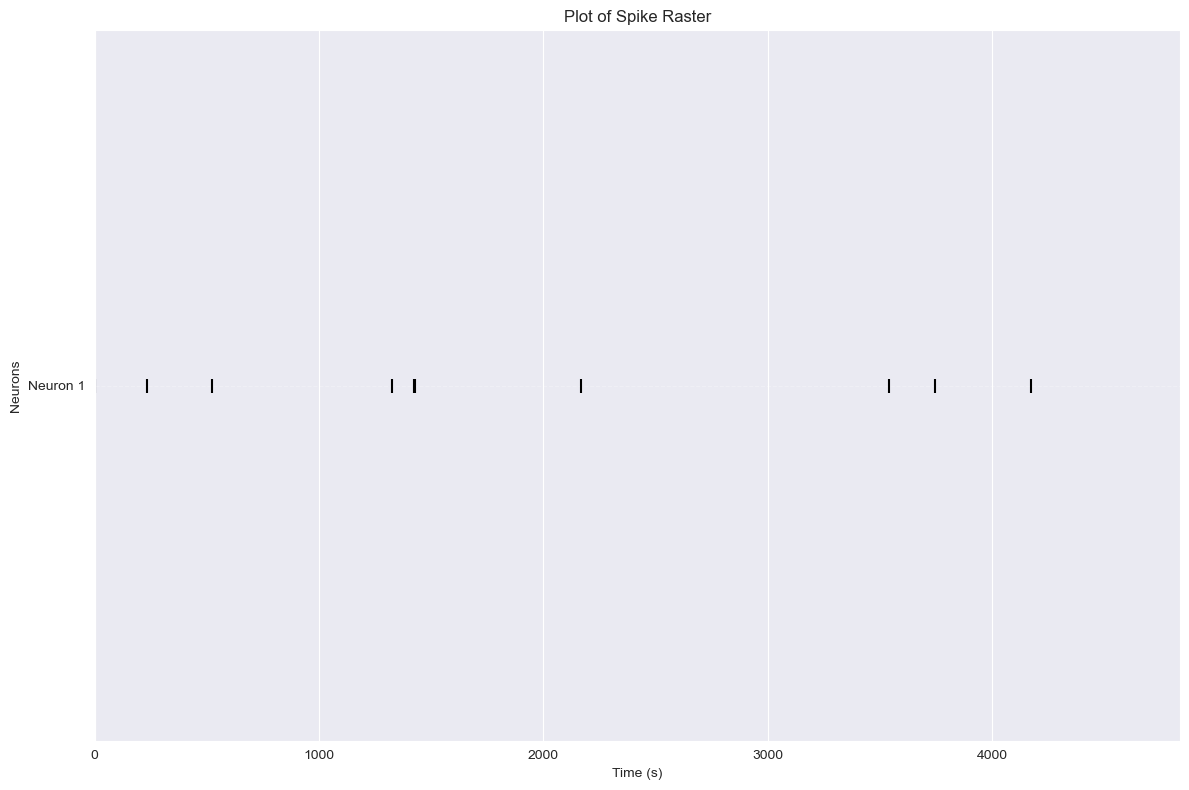

Time where spikes happened (indices): [1019 1389 1590 1991 2088 2089 2392 3086 3320 3385 3394 3408 3458 3554
 3717 3862 3997 4152 4377 4378 4534 4636 4669]
Total simulation duration (in ms): 483.6
Number of spikes: 14.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3   12 1593 1994 2091 3388 3397 3411 3461 3557 3865 4000 4380 4537]
Number of neurons: 1, Spike shape: (4836, 1)


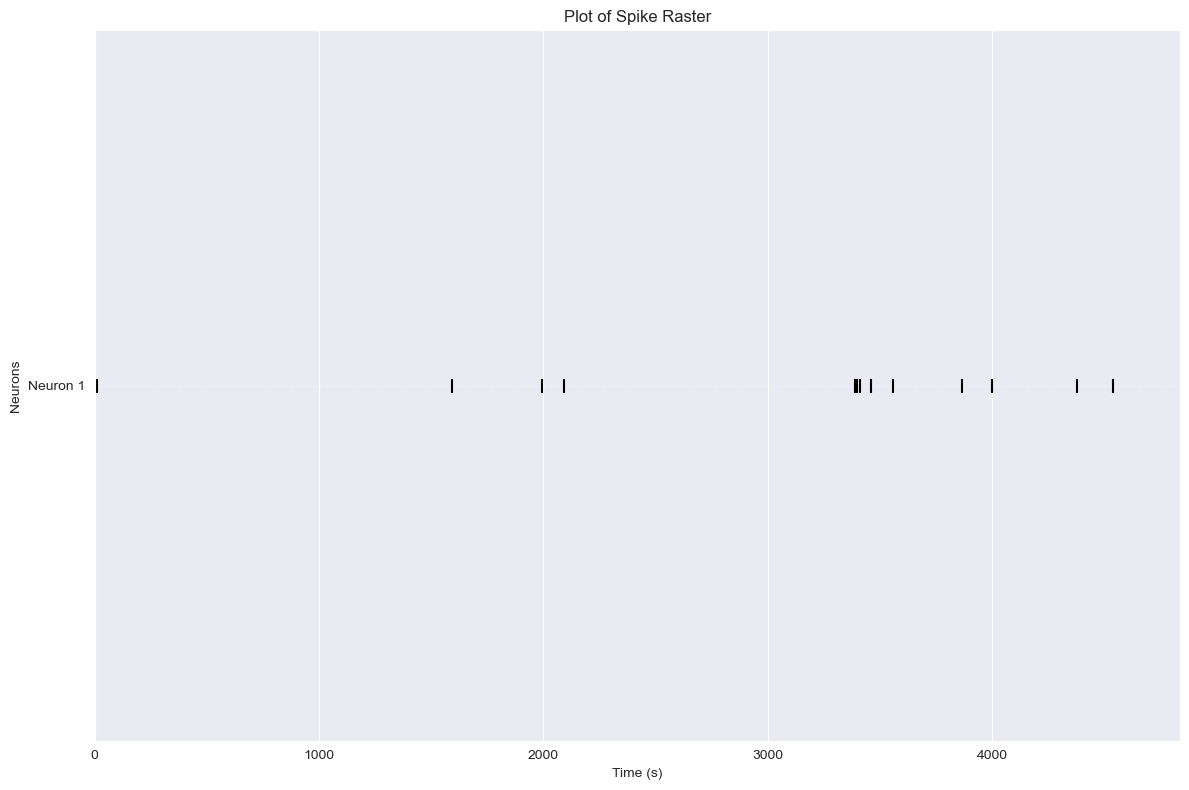

In [67]:
"""
Now for all six neurons we are going to simulate the network.
1. We have already demo using one spike. which is good.
2. We use psc from both neurons and ipsc to demo all neurons.
"""
input_currents = {
    'U_0': 0.3,
    'psc': np.array([]),
    'ipsc': ''
}
time1, U_plot1, neuron_1 = artificial_neuron_simulation(first_neuron)
time2, U_plot2, neuron_2 = artificial_neuron_simulation(second_neuron, ipsc=np.array([1]),input_currents=input_currents)
# time3, U_plot3, neuron_3 = artificial_neuron_simulation(third_neuron, ipsc=np.array([]))
# time4, U_plot4, neuron_4 = artificial_neuron_simulation(fourth_neuron, ipsc=np.array([]))
# time5, U_plot5, neuron_5 = artificial_neuron_simulation(fifth_neuron, ipsc=np.array([]))
# time6, U_plot6, neuron_6 = artificial_neuron_simulation(sixth_neuron, ipsc=np.array([]))



In [65]:
count_rate_neuron = neuron_1.sum() / total_simulation_time
print(f'The count rate of the first neuron is {count_rate_neuron} Hz')

The count rate of the first neuron is 0.3308519437551696 Hz


# PART 2 : The Decoding

## 1. Loading the Dataset

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('DataSetCoursework_AMA.txt', sep=r'\s+', header=None) # Loading the data in pandas dataframe
data.head() # Column from 0 to 5 represent record of the spike, column 6 represent the behaviour column 7 represent trial number

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [82]:
# Checking for missing values and information of the data.
print(f'The total length of the data : {len(data)}')
print(data.isna().sum()) # It shows there is no missing values.

The total length of the data : 4836
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


In [83]:
bin_size = 0.01 # Provided by the dataset
num_of_rows = data.shape[0]
time_duration = num_of_rows * bin_size
print(f'The total duration of the data is {time_duration:.2f} seconds')

The total duration of the data is 48.36 seconds


In [84]:
print(np.sum(data[data.iloc[:, 0] != 0][0]))
data.nunique() # The number of uniques across each column.

17.0


0     2
1     2
2     3
3     3
4     2
5     3
6     4
7    20
dtype: int64

## 2. Linear Discriminant Analysis
> We initially used Linear Discriminant Analysis with no firing rate. To see the model improvement

In [ ]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
lda = LinearDiscriminantAnalysis()
loo = LeaveOneOut()
spikes = data.iloc[:, :-2].values
target = data.iloc[:, -2].values
X_train, X_test, y_train, y_test = train_test_split(spikes, target, test_size=0.2, random_state=42)
#scores = cross_val_score(lda, X_train, y_train, cv=LeaveOneOut())
import time
start_time = time.time()
scores = cross_val_score(lda, spikes, target, cv=loo, scoring='accuracy')
end_time = time.time()
print(f'Mean accuracy: {scores.mean():.3f}')
print(f'Time taken: {end_time - start_time:.2f} seconds')
lda2 = LinearDiscriminantAnalysis()
lda2.fit(X_train, y_train)

train_score = lda2.score(X_train, y_train)
test_score = lda2.score(X_test, y_test)
print(f'Test score: {test_score:.3f}')
print(f'Train score: {train_score:.3f}')

## 3. Firing rate Calculation
> We reused the function with a little modification to calculate the firing rate of the neurons. please uncomment the function to edit which dataset you want to use.

In [86]:
def rates1_calculate(spikes, window_size, bin_size=0.01):
    '''
    This function calculates the firing rate of the neurons, by explicitly using the window size.
    Produced By Emily B-B, Bournemouth University edited to fit our assignment requirements.

    :param spikes: the neuron spike train (numpy array or loaded from a file)
    :param window_size: size of the time window in seconds (e.g., 0.2 seconds)
    :param bin_size: size of each time snapshot (e.g., 0.01 seconds per row, provided by the dataset)
    :return: The firing rate of the neurons and a function for plotting
    '''
    if spikes is None:  # If no spike data is provided, load from the default file
        spikes = np.loadtxt('DataSetCoursework_AMA.txt') or 'DataSetCoursework_POG.txt'

    # Extract last column as the trial number
    trial_num = spikes[:, -1]  # Stores trial identifiers for each row

    # Remove last two columns (to focus only on spike data)
    spikes = spikes[:, :-2]

    # Get the dimensions: n = number of time steps, m = number of neurons
    n, m = spikes.shape

    # Create a time vector based on bin_size and number of rows
    times = np.arange(0, n * bin_size, bin_size)

    # Calculate window steps: the number of rows corresponding to the given window size
    window_steps = round(window_size / bin_size)

    # Initialize a rate matrix of zeros
    rate = np.zeros((n, m))

    # Loop through each neuron
    for j in range(m):
        smoothed = []

        # For each neuron, apply a sliding window technique to calculate firing rate
        for i in range(n - window_steps + 1):  # Loop over time steps
            # Select the spike count data for the current time window
            spikes_one_neuron = spikes[i:i + window_steps, j]

            # Compute the firing rate: sum of spikes in the window divided by window size
            rate_in_this_window = np.sum(spikes_one_neuron) / window_size

            # Append the calculated rate to the smoothed list (firing rate over time)
            smoothed.append(rate_in_this_window)

        # To match the shape of the original data, repeat the last value for the remaining steps
        smoothed.extend([smoothed[-1]] * (window_steps - 1))

        # Store the smoothed rates for the current neuron into the rate matrix
        rate[:, j] = smoothed

    # Add trial number as the last column of the rate matrix
    rate = np.column_stack((rate, trial_num))

    # Define the plotting function
    def plot_rate():
        '''
        This function plots the spike train and firing rate for each neuron.
        It uses the `spikes` and `rate` calculated in the parent function.
        '''
        fig, axs = plt.subplots(m, 2, figsize=(10, m * 2))  # Create subplots for all neurons
        for j in range(m):  # Loop to plot for each neuron
            # Plot spike train on the left
            axs[j, 0].plot(times, spikes[:, j], 'b')
            axs[j, 0].set_title(f'Neuron {j + 1}')  # Title for the subplot
            axs[j, 0].set_ylabel('Spikes')  # Y-axis label
            axs[j, 0].set_xlabel('Time (s)')  # X-axis label

            # Plot firing rate on the right
            axs[j, 1].plot(times, rate[:, j], 'r')
            axs[j, 1].set_title(f'Neuron {j + 1} rate')  # Title for the subplot
            axs[j, 1].set_ylabel('Spikes/sec')  # Y-axis label
            axs[j, 1].set_xlabel('Time (s)')  # X-axis label

        plt.tight_layout()  # Adjust layout for readability
        plt.show()  # Display the plots

    # Return both the rate matrix and the plot logic
    return rate, plot_rate


In [87]:
'''
Calling the rate function with another dataset. (please un comment to load another dataset)
'''
spikes = np.loadtxt('DataSetCoursework_POG.txt')# or 'DataSetCoursework_AMA.txt')
rate, plot_rate = rates1_calculate(spikes=spikes, window_size=1.7,)
rate

array([[ 0.58823529,  1.76470588,  0.58823529, ...,  1.17647059,
         2.35294118,  1.        ],
       [ 0.58823529,  1.76470588,  0.58823529, ...,  1.17647059,
         2.35294118,  1.        ],
       [ 0.58823529,  1.76470588,  0.58823529, ...,  1.17647059,
         2.35294118,  1.        ],
       ...,
       [ 0.58823529,  0.        ,  0.58823529, ...,  4.11764706,
         0.58823529, 20.        ],
       [ 0.58823529,  0.        ,  0.58823529, ...,  4.11764706,
         0.58823529, 20.        ],
       [ 0.58823529,  0.        ,  0.58823529, ...,  4.11764706,
         0.58823529, 20.        ]])

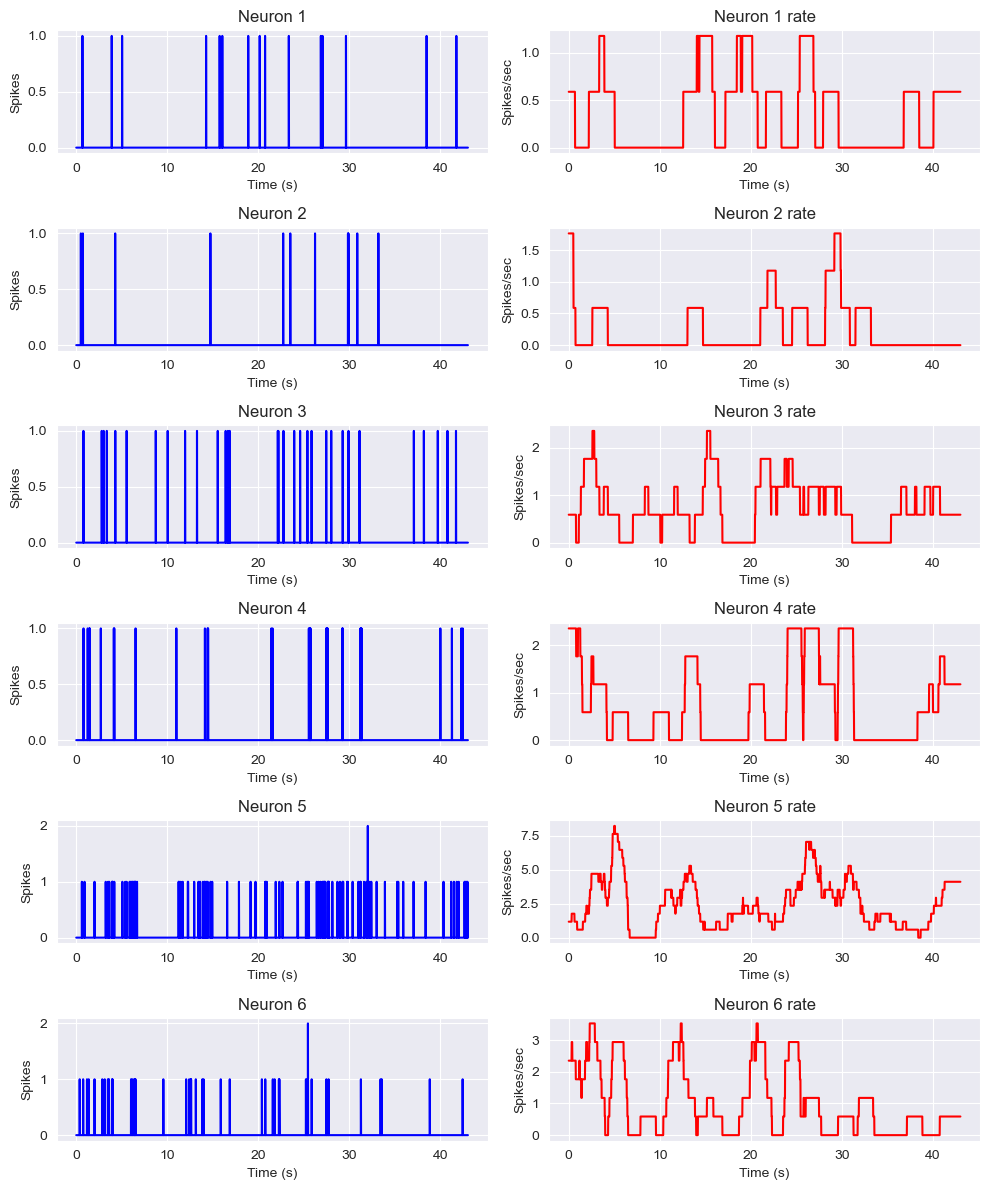

In [88]:
'''
Plotting the rate function.
'''
plot_rate()

## 4. Linear Discriminant Analysis with Firing rate
> Now we use the LinearDiscriminantAnalysis with firing rate as the feature to see if the model has improved further.
Also we test over different time windows to get the best time window the model can get.

In [89]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
import time

def model_rate(spikes, target, window_sizes, bin_size=0.01, test_size=0.2, random_state=42):
    '''
    This function gets the model using the firing rate of the neurons at different window sizes.
    Developed By Gerald Bournemouth, and Modified by ChatGPT generative AI.
    This function calculates the model Using Linear Discriminant Analysis and get the comparison between the
    firing rate of the neurons at different window sizes to spikes with no firing rate.
    :param spikes: the spike train as numpy array
    :param target: the target column as numpy array
    :param window_sizes: the window sizes to be used
    :param bin_size: the snapshot time window
    :param test_size: a random parameter for train/test split
    :param random_state: random seed
    :return: performances and optimal window size
    '''

    performances = {}
    lda = LinearDiscriminantAnalysis()

    for window_size in window_sizes:
        rate, _ = rates1_calculate(spikes, window_size, bin_size) # get individual rate at specific window_size
        X_train, X_test, y_train, y_test = train_test_split(rate, target, test_size=test_size, random_state=random_state)

        loo = LeaveOneOut()
        start_time = time.time()
        scores = cross_val_score(lda, rate[:, :-1],target, cv=loo, scoring='accuracy')
        loo_time = time.time() - start_time

        # Model for train/test scores
        lda.fit(X_train, y_train)
        train_score = lda.score(X_train, y_train)
        test_score = lda.score(X_test, y_test)

        performances[window_size] = {
            'mean_accuracy': scores.mean(),
            'train_score': train_score,
            'test_score': test_score,
            'loo_time': loo_time
        }
        print(f'Window size : {window_size}, Mean Accuracy : {scores.mean():.3f}, '
              f'Train Accuracy : {train_score:.3f}, Test Accuracy : {test_score:.3f}, LOO Time : {loo_time:.2f}')
        print(f'Total time taken : {loo_time:.2f} seconds')
    optimal_window_size = max(performances, key=lambda k: performances[k]['test_score'])
    return performances, optimal_window_size

In [90]:
# Initializing window sizes and loading the spikes and target predicted variable to the model_rate function
window_sizes = np.arange(0.1, 2.8, 0.1)
spikes = np.loadtxt('DataSetCoursework_POG.txt')
target = spikes[:,-2].astype(int)
performances, optimal_window_size = model_rate(spikes, target, window_sizes) # Returns the performance and the optimal window sizes.
print(f'Optimal window size : {optimal_window_size} \n performances are : {performances[optimal_window_size]}')

Window size : 0.1, Mean Accuracy : 0.492, Train Accuracy : 0.503, Test Accuracy : 0.511, LOO Time : 5.17
Total time taken : 5.17 seconds
Window size : 0.2, Mean Accuracy : 0.533, Train Accuracy : 0.544, Test Accuracy : 0.525, LOO Time : 5.13
Total time taken : 5.13 seconds
Window size : 0.30000000000000004, Mean Accuracy : 0.519, Train Accuracy : 0.555, Test Accuracy : 0.544, LOO Time : 5.08
Total time taken : 5.08 seconds
Window size : 0.4, Mean Accuracy : 0.551, Train Accuracy : 0.571, Test Accuracy : 0.555, LOO Time : 5.94
Total time taken : 5.94 seconds
Window size : 0.5, Mean Accuracy : 0.563, Train Accuracy : 0.593, Test Accuracy : 0.571, LOO Time : 5.09
Total time taken : 5.09 seconds
Window size : 0.6000000000000001, Mean Accuracy : 0.597, Train Accuracy : 0.632, Test Accuracy : 0.621, LOO Time : 5.14
Total time taken : 5.14 seconds
Window size : 0.7000000000000001, Mean Accuracy : 0.619, Train Accuracy : 0.652, Test Accuracy : 0.652, LOO Time : 5.36
Total time taken : 5.36 sec

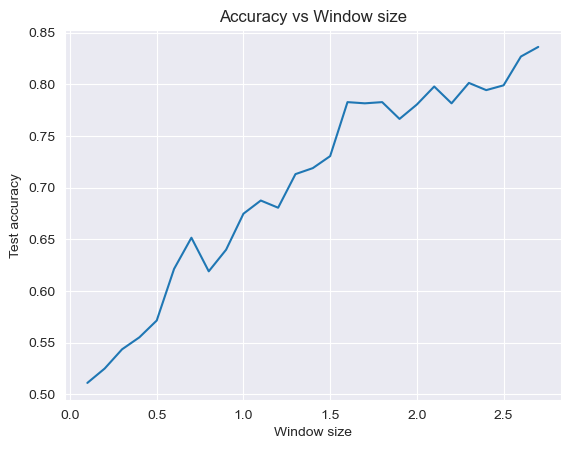

In [91]:
test_accuracy = [performances[i]['test_score'] for i in performances.keys()]
window_sizes = [i for i in performances.keys()]
plt.plot(window_sizes, test_accuracy)
plt.xlabel('Window size')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs Window size')
plt.show()

> As the window size increases the model testing performances also increases which shows a significant choice how the patterns have been captured by the model. But at certain point the model no longer learns from increases performance by much.
We have chosen the max performance performed by the model.

## 5. Random Forest Classifier
> We created the RFC to see if we can get other model improvement compared to LinearDiscriminantAnalysis.
The function accepts `spikes`, `target`, `window size` and `model save path`.

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
import time
import joblib

def model_rate_1(spikes, target,windows_size,model_path, random_state=42):

    performances = {}

    kflod = KFold(n_splits=5, shuffle=True, random_state=random_state)
    best_model = None
    best_window_size = None

    for window_size in window_sizes:
        rate, _ = rates1_calculate(spikes, window_size, bin_size) # get individual rate at specific window_size

        rf = RandomForestClassifier()

        start_time = time.time()
        scores = cross_val_score(rf, rate[:, :-1],target, cv=kflod, scoring='accuracy')
        rf_time = time.time() - start_time

        performances[window_size] = {
            'mean_accuracy': scores.mean(),
            'rf_time': rf_time
        }
        print(f'Window size : {window_size}, Mean Accuracy : {scores.mean():.3f}, RF Time : {rf_time:.2f}')
        print(f'Total time taken : {rf_time:.2f} seconds')
        if best_window_size is None or scores.mean() > performances[best_window_size]['mean_accuracy']:
            rf.fit(rate[:, :-1], target)
            best_model = rf
            best_window_size = window_size
    joblib.dump(best_model, model_path)

    return performances, best_window_size

In [95]:
"""
Loading the spikes and target predicted variable to the model_rate_1 function.
Please uncomment to load another dataset.
"""
window_sizes = np.arange(0.1, 2.7, 0.1)
spikes = np.loadtxt('DataSetCoursework_AMA.txt') #or 'DataSetCoursework_POG.txt')
model_path = 'model_rf.pkl'
target = spikes[:,-2].astype(int)
performances, optimal_window_size = model_rate_1(spikes=spikes, target=target, windows_size=window_sizes,model_path=model_path)

Window size : 0.1, Mean Accuracy : 0.506, RF Time : 0.30
Total time taken : 0.30 seconds
Window size : 0.2, Mean Accuracy : 0.594, RF Time : 0.35
Total time taken : 0.35 seconds
Window size : 0.30000000000000004, Mean Accuracy : 0.661, RF Time : 0.36
Total time taken : 0.36 seconds
Window size : 0.4, Mean Accuracy : 0.744, RF Time : 0.37
Total time taken : 0.37 seconds
Window size : 0.5, Mean Accuracy : 0.804, RF Time : 0.40
Total time taken : 0.40 seconds
Window size : 0.6000000000000001, Mean Accuracy : 0.841, RF Time : 0.40
Total time taken : 0.40 seconds
Window size : 0.7000000000000001, Mean Accuracy : 0.879, RF Time : 0.40
Total time taken : 0.40 seconds
Window size : 0.8, Mean Accuracy : 0.904, RF Time : 0.43
Total time taken : 0.43 seconds
Window size : 0.9, Mean Accuracy : 0.925, RF Time : 0.40
Total time taken : 0.40 seconds
Window size : 1.0, Mean Accuracy : 0.947, RF Time : 0.39
Total time taken : 0.39 seconds
Window size : 1.1, Mean Accuracy : 0.961, RF Time : 0.39
Total t

In [96]:
print(f'Optimal window size : {optimal_window_size} \n performances are : {performances[optimal_window_size]}')


Optimal window size : 2.1 
 performances are : {'mean_accuracy': 0.9838708367875426, 'rf_time': 0.3890819549560547}


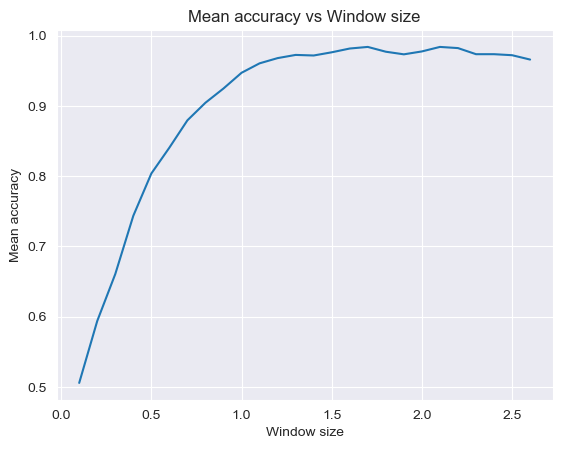

In [97]:
mean_accuracy = [performances[i]['mean_accuracy'] for i in performances.keys()]
window_sizes = [i for i in performances.keys()]
plt.plot(window_sizes, mean_accuracy)
plt.xlabel('Window size')
plt.ylabel('Mean accuracy')
plt.title('Mean accuracy vs Window size')
plt.show()

> Finally we can conclude that as the window sizes increases we see the model performances with firing rate are better than without firing rate.